In [ ]:
# ✅ 1. Imports e configuração inicial
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

print("TensorFlow Version:", tf.__version__)
AUTOTUNE = tf.data.AUTOTUNE


TensorFlow Version: 2.18.0


In [ ]:
# ✅ 2. Carregamento do Dataset Cats vs Dogs via TFDS
(ds_train, ds_val), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    with_info=True,
)

# Visualizar classes
print("Classes:", ds_info.features['label'].names)


Classes: ['cat', 'dog']


In [ ]:
# ✅ 3. Preprocessamento (resize e normalização)
def preprocess(image, label):
    image = tf.image.resize(image, (160, 160))
    image = image / 255.0
    return image, label

batch_size = 32

ds_train = ds_train.map(preprocess).shuffle(1000).batch(batch_size).prefetch(AUTOTUNE)
ds_val = ds_val.map(preprocess).batch(batch_size).prefetch(AUTOTUNE)


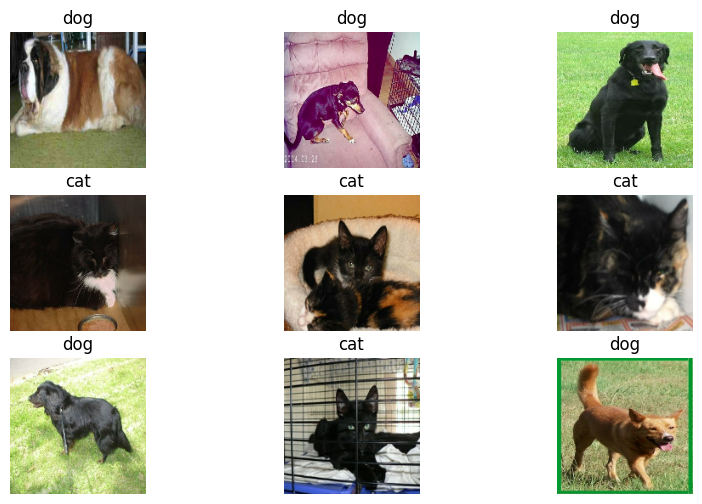

In [ ]:
# ✅ 4. Visualização de amostras do dataset
class_names = ds_info.features['label'].names

plt.figure(figsize=(10, 6))
for images, labels in ds_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(class_names[labels[i]])
        plt.axis("off")


In [ ]:
# ✅ 5. Construção do Modelo com Transfer Learning (MobileNetV2)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(160, 160, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Congelar as camadas da base

# Adicionar "cabeça" personalizada
inputs = tf.keras.Input(shape=(160, 160, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs, outputs)

# Compilar modelo
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
model.save('cats_vs_dogs_model.h5')


In [ ]:
# ✅ 6. Treinamento Inicial (base congelada)
initial_epochs = 5

history = model.fit(
    ds_train,
    epochs=initial_epochs,
    validation_data=ds_val
)


Epoch 1/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 569s 959ms/step - accuracy: 0.9524 - loss: 0.1303 - val_accuracy: 0.9794 - val_loss: 0.0610
Epoch 2/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 511s 875ms/step - accuracy: 0.9798 - loss: 0.0577 - val_accuracy: 0.9779 - val_loss: 0.0628
Epoch 3/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 553s 948ms/step - accuracy: 0.9823 - loss: 0.0533 - val_accuracy: 0.9822 - val_loss: 0.0572
Epoch 4/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 514s 879ms/step - accuracy: 0.9837 - loss: 0.0464 - val_accuracy: 0.9766 - val_loss: 0.0617
Epoch 5/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 514s 880ms/step - accuracy: 0.9850 - loss: 0.0450 - val_accuracy: 0.9804 - val_loss: 0.0577


In [ ]:
# ✅ 7. Fine-tuning (opcional)
# Descongelar as últimas camadas da base
base_model.trainable = True
fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Compilar novamente com learning rate menor
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

fine_tune_epochs = 5
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(
    ds_train,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=ds_val
)


Epoch 5/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 826s 1s/step - accuracy: 0.9100 - loss: 0.2239 - val_accuracy: 0.9731 - val_loss: 0.0807
Epoch 6/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 787s 1s/step - accuracy: 0.9681 - loss: 0.0832 - val_accuracy: 0.9764 - val_loss: 0.0688
Epoch 7/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 775s 1s/step - accuracy: 0.9782 - loss: 0.0567 - val_accuracy: 0.9755 - val_loss: 0.0663
Epoch 8/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 816s 1s/step - accuracy: 0.9851 - loss: 0.0431 - val_accuracy: 0.9759 - val_loss: 0.0673
Epoch 9/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 773s 1s/step - accuracy: 0.9894 - loss: 0.0333 - val_accuracy: 0.9761 - val_loss: 0.0661
Epoch 10/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 785s 1s/step - accuracy: 0.9927 - loss: 0.0254 - val_accuracy: 0.9757 - val_loss: 0.0665


In [ ]:
# ✅ 8. Salvar modelo treinado
model.save("cats_vs_dogs_mobilenetv2.h5")


Saving canva-beautiful-golden-retriever-dog-breed-MACyjPLo0-I.png to canva-beautiful-golden-retriever-dog-breed-MACyjPLo0-I.png


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predição: Cachorro (1.00)


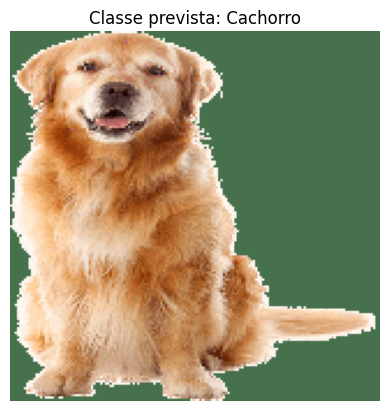

In [ ]:
# ✅ 9. Testar com uma imagem nova (upload manual)
from google.colab import files
from tensorflow.keras.preprocessing import image
import numpy as np

uploaded = files.upload()

for fn in uploaded.keys():
    img_path = fn
    img = image.load_img(img_path, target_size=(160, 160))
    img_array = image.img_to_array(img) / 255.0
    img_array = tf.expand_dims(img_array, 0)  # Criar batch

    prediction = model.predict(img_array)[0][0]
    class_pred = "Cachorro" if prediction > 0.5 else "Gato"
    print(f"Predição: {class_pred} ({prediction:.2f})")
    plt.imshow(img)
    plt.title(f"Classe prevista: {class_pred}")
    plt.axis('off')
    plt.show()


Saving gato.jpg to gato.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
Predição: Gato (0.00)


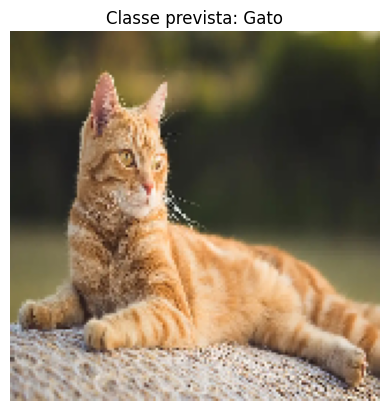

In [ ]:
# ✅ 9. Testar com uma imagem nova (upload manual)
from google.colab import files
from tensorflow.keras.preprocessing import image
import numpy as np

uploaded = files.upload()

for fn in uploaded.keys():
    img_path = fn
    img = image.load_img(img_path, target_size=(160, 160))
    img_array = image.img_to_array(img) / 255.0
    img_array = tf.expand_dims(img_array, 0)  # Criar batch

    prediction = model.predict(img_array)[0][0]
    class_pred = "Cachorro" if prediction > 0.5 else "Gato"
    print(f"Predição: {class_pred} ({prediction:.2f})")
    plt.imshow(img)
    plt.title(f"Classe prevista: {class_pred}")
    plt.axis('off')
    plt.show()
